## Importing Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import keras
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.model_selection import train_test_split

from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras import models
from keras.layers.core import Dense , Flatten , Dropout 
from keras.models import Sequential
from keras.layers import Activation , Conv2D , MaxPooling2D, Lambda, ZeroPadding2D, Convolution2D
from keras.preprocessing.image import ImageDataGenerator
# from keras import backend as K

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames[:2]:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
submission_names = '/kaggle/input/aptos2019-blindness-detection/sample_submission.csv'
train_names = "/kaggle/input/aptos2019-blindness-detection/train.csv"
test_names = "/kaggle/input/aptos2019-blindness-detection/test.csv"

test_images_path = "/kaggle/input/aptos2019-blindness-detection/test_images/"
train_images_path = "/kaggle/input/aptos2019-blindness-detection/train_images/"

train_data = pd.read_csv(train_names)
train_data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
trainX , testX , trainY , testY = train_test_split(train_data['id_code'], train_data['diagnosis'], test_size=0.2)

## Image Preprocessing

In [4]:
IMAGE_SHAPE = (120, 120, 3)
IMAGE_SIZE = (120, 120)

def preprocess_image(image):
    
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 30), -4, 128)
    
    height, width, _ = image.shape
    center_x = int(width / 2)
    center_y = int(height / 2)
    radius = min(center_x, center_y)
    
    circle_mask = np.zeros((height, width), np.uint8)
    cv2.circle(circle_mask, (center_x, center_y), radius, color=1, thickness=-1)
    image = cv2.resize(cv2.bitwise_and(image, image, mask=circle_mask)[center_y - radius:center_y + radius, center_x - radius:center_x + radius], IMAGE_SIZE)
    return image

In [5]:
def getting_image_from_path(img_id, common_path):
    img_url = common_path + str(img_id + ".png")
    img = cv2.imread(img_url) # 1 = color && 0 = black&white
    imgs =  preprocess_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     imgs = cv2.resize(img, (260, 260)) # (height, width) pixels for img resolution try 480, 640
    return imgs

def data_maker(img_ids , labels, common_train_test_path, size):
    img_lst = []
    for i in img_ids[:int(size)]:
        image = getting_image_from_path(str(i), common_train_test_path)
        img_lst.append(image)
        
    return np.array(img_lst), np.array(labels[:int(size)])

In [6]:
train_imgs, train_labels = data_maker(trainX, trainY, train_images_path, len(trainY))
test_imgs, test_labels = data_maker(testX, testY, train_images_path, len(testY))

## Visualization

[0 1 0 4 0 2 1 0 0 2]


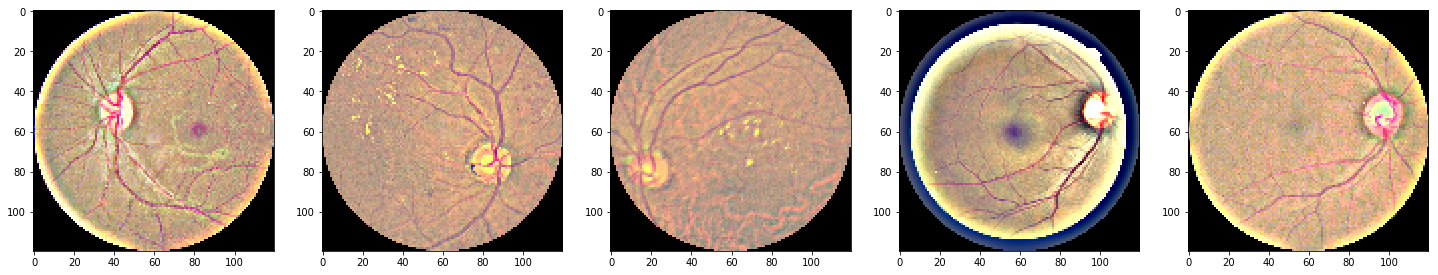

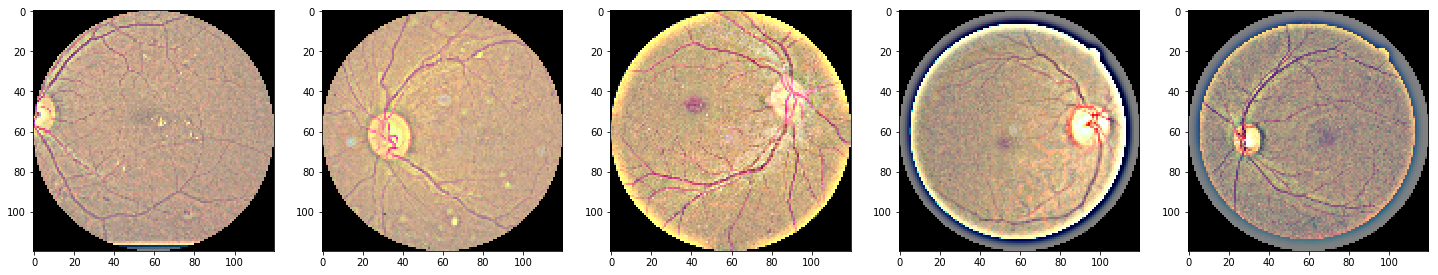

In [7]:
# Plotting the Images Graph

for i in range(10):
        if (i % 5) == 0:
            fig, ax = plt.subplots(1,5,figsize=(25,5)) 
        else:
            k = i
            for j in range(5):
                ax[j].imshow(train_imgs[k])
                k = k + 1
                
print(train_labels[:10])

## One Hot Encoding

In [8]:
def one_hot_encoding(list_of_target):
    one_hot_lst = []
    lst = pd.get_dummies(np.unique(list_of_target))
#     print(lst)
    for i in list_of_target:
        a = np.array(lst[i]).tolist()
        one_hot_lst.append(a)
    return np.array(one_hot_lst) , len(lst)

# print(one_hot_encoding(train_labels))

## Code for saving & loading back the training model****

In [9]:
def saving_model(model_instance,model_name):
    model_instance.save(str(model_name))
    print("Model Saved")
    
def loading_model(model_name):
    model = models.load_model(str(model_name))
    print("Model Loaded")
    return model

## Making the model

In [10]:
SHAPE = (120, 120,3)
###################################

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape= SHAPE))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

####################################
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 58, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 215296)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                13779008  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # try optimizer sgd with vgg16

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

datagen.fit(train_imgs)
history = model.fit_generator(datagen.flow(train_imgs, one_hot_encoding(train_labels)[0], batch_size=32),
                        steps_per_epoch=len(train_imgs) / 32,
                        validation_data=datagen.flow(test_imgs, one_hot_encoding(test_labels)[0], batch_size=32),
                        validation_steps=len(test_imgs) / 32,
                        epochs=100)

Epoch 1/100
92/91 [==============================] - 22s 237ms/step - loss: 2.1010 - acc: 0.5230 - val_loss: 0.9540 - val_acc: 0.6958
Epoch 2/100
92/91 [==============================] - 14s 153ms/step - loss: 0.9601 - acc: 0.6690 - val_loss: 0.8496 - val_acc: 0.7244
Epoch 3/100
92/91 [==============================] - 13s 145ms/step - loss: 0.9224 - acc: 0.6843 - val_loss: 0.8220 - val_acc: 0.7244
Epoch 4/100
92/91 [==============================] - 14s 147ms/step - loss: 0.9030 - acc: 0.6908 - val_loss: 0.7864 - val_acc: 0.7326
Epoch 5/100
92/91 [==============================] - 14s 150ms/step - loss: 0.8935 - acc: 0.6894 - val_loss: 0.8335 - val_acc: 0.7094
Epoch 6/100
92/91 [==============================] - 14s 157ms/step - loss: 0.8806 - acc: 0.6932 - val_loss: 0.8010 - val_acc: 0.7285
Epoch 7/100
92/91 [==============================] - 13s 146ms/step - loss: 0.8700 - acc: 0.6950 - val_loss: 0.8094 - val_acc: 0.7299
Epoch 8/100
92/91 [==============================] - 14s 147ms

1. 1. ## Plotting accuracy & loss graph

In [13]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


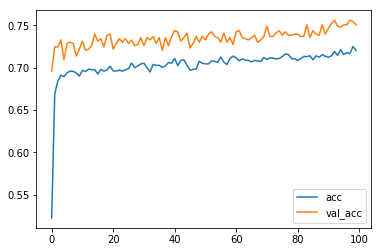

In [14]:
# Accuracy Graph
plt.plot(history.epoch, history.history['acc'] , label="acc")
plt.plot(history.epoch, history.history['val_acc'] , label = "val_acc")
plt.legend()
plt.show()

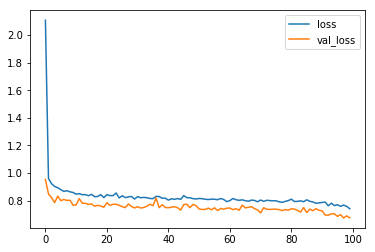

In [15]:
# Loss Graph
plt.plot(history.epoch, history.history['loss'] , label = "loss")
plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")
plt.legend()
plt.show()

In [16]:
# Now Making the Prediction and Evaluating the model

score = model.evaluate(test_imgs, one_hot_encoding(test_labels)[0], verbose = 0)
print("%s: %.2f%%" % ("acc", score[1]*100))

acc: 48.43%


### Predicting the model and Saving in CSV

In [17]:
sub_file = pd.read_csv(submission_names)
sub_file.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [18]:
length = len(sub_file['diagnosis'])
#####################

val = data_maker(sub_file["id_code"], sub_file['diagnosis'], test_images_path, length)[0]
pred = model.predict_classes(val)
print(pred[:10])

[0 0 0 0 0 0 0 0 0 0]


In [19]:
df = pd.DataFrame(data = {"id_code": sub_file["id_code"], "diagnosis": pred })
df.to_csv("submission.csv", sep = ",", index = False)
print("Done")

Done


In [20]:
# Can do TTA (test time Augmentation) and blending of model for better accuracy